In [1]:
from __future__ import print_function
import numpy as np
try:
    import cPickle as pickle
except ImportError:
    import pickle
import tensorflow as tf
%matplotlib inline

import matplotlib.pyplot as plt
import math

In [2]:
import sys
if sys.version_info.major > 2:
    xrange = range
del sys

In [3]:
import gym
env = gym.make('CartPole-v0')

[2018-02-13 18:31:13,142] Making new env: CartPole-v0


### Setting Hyper-parameters

In [4]:
# hyperparameters ?
H = 8 # number of hidden layer neurons
learning_rate = 1e-2
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2 ?
resume = False # resume from previous checkpoint?

model_bs = 3 # Batch size when learning from model
real_bs = 3 # Batch size when learning from real environment

# model initialization
D = 4 # input dimensionality ?

### Policy Network

In [5]:
tf.reset_default_graph() # reset tensorflow graph
observations = tf.placeholder(tf.float32, [None,4], name="input_x")
W1 = tf.get_variable("W1", shape=[4, H], 
                    initializer=tf.contrib.layers.xavier_initializer())
layer1 = tf.nn.relu(tf.matmul(observations,W1))
W2 = tf.get_variable("W2", shape=[H, 1], 
                    initializer=tf.contrib.layers.xavier_initializer())
score = tf.matmul(layer1,W2)
probability = tf.nn.sigmoid(score) 

tvars = tf.trainable_variables()
input_y = tf.placeholder(tf.float32, [None, 1], name="input_y")
advantages = tf.placeholder(tf.float32, name="reward_signal")
adam = tf.train.AdamOptimizer(learning_rate=learning_rate)
W1Grad = tf.placeholder(tf.float32, name="batch_grad1")
W2Grad = tf.placeholder(tf.float32, name="batch_grad2")
batchGrad = [W1Grad,W2Grad]
loglik = tf.log(input_y*(input_y - probability) + (1 - input_y)*(input_y + probability))
loss = -tf.reduce_mean(loglik*advantages)
newGrads = tf.gradients(loss, tvars)
updateGrads = adam.apply_gradients(zip(batchGrad,tvars))

### Model Network
Implement a multi-layer neural network that predicts the next observation, rewrad, and done state from a current state and action

In [6]:
mH = 256 # model layer size

input_data = tf.placeholder(tf.float32, [None, 5])
with tf.variable_scope('rnnlm'):
    softmax_w = tf.get_variable("softmax_w", [mH, 50])
    softmax_b = tf.get_variable("softmax_b", [50])
    
previous_state = tf.placeholder(tf.float32, [None,5], name="previous_state")
W1M = tf.get_variable("W1M", shape=[5, mH],
                     initializer=tf.contrib.layers.xavier_initializer())
B1M = tf.Variable(tf.zeros([mH]), name="B1M")
layer1M = tf.nn.relu(tf.matmul(previous_state, W1M) + B1M)
W2M = tf.get_variable("W2M", shape=[mH, mH],
                     initializer=tf.contrib.layers.xavier_initializer())
B2M = tf.Variable(tf.zeros([mH]), name="B2M")
layer2M = tf.nn.relu(tf.matmul(layer1M, W2M) + B2M)
wO = tf.get_variable("wO", shape=[mH, 4],
                    initializer=tf.contrib.layers.xavier_initializer())
wR = tf.get_variable("wR", shape=[mH, 1],
                    initializer=tf.contrib.layers.xavier_initializer())
wD = tf.get_variable("wD", shape=[mH, 1],
                    initializer=tf.contrib.layers.xavier_initializer())

bO = tf.Variable(tf.zeros([4]), name="bO")
bR = tf.Variable(tf.zeros([1]), name="bR")
bD = tf.Variable(tf.zeros([1]), name="bD")

predicted_observation = tf.matmul(layer2M,wO,name="predicted_observation") + bO
predicted_reward = tf.matmul(layer2M, wR, name="predicted_reward") + bR
predicted_done = tf.sigmoid(tf.matmul(layer2M, wD, name="prediced_done") + bD)

true_observation = tf.placeholder(tf.float32, [None, 4], name="true_observation")
true_reward = tf.placeholder(tf.float32, [None,1], name="true_reward")
true_done = tf.placeholder(tf.float32, [None,1], name="true_done")

predicted_state = tf.concat([predicted_observation, predicted_reward, predicted_done], 1)
observation_loss = tf.square(true_observation - predicted_observation)
reward_loss = tf.square(true_reward - predicted_reward)

done_loss = tf.multiply(predicted_done, true_done) + tf.multiply(1-predicted_done, 1-true_done)
done_loss = -tf.log(done_loss)

model_loss = tf.reduce_mean(observation_loss + done_loss + reward_loss)

modelAdam = tf.train.AdamOptimizer(learning_rate=learning_rate)
updateModel = modelAdam.minimize(model_loss)

### Helper-functions?

In [7]:
def resetGradBuffer(gradBuffer):
    for ix, grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
    return gradBuffer

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward"""
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

# This function uses our model to produce a new state when given a previous state and action
def stepModel(sess, xs, action):
    toFeed = np.reshape(np.hstack([xs[-1][0],np.array(action)]), [1,5])
    myPredict = sess.run([predicted_state], feed_dict={previous_state: toFeed})
    reward = myPredict[0][:,4]
    observation = myPredict[0][:,0:4]
    observation[:,0] = np.clip(observation[:,0],-2.4,2.4)
    observation[:,2] = np.clip(observation[:,2],-0.4,0.4)
    doneP = np.clip(myPredict[0][:,5],0,1)
    if doneP > 0.1 or len(xs) >= 300:
        done = True
    else:
        done = False
    return observation, reward, done

    

### Training the Policy and Model

In [10]:
xs, drs, ys, ds = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 1
real_episodes = 1
init = tf.global_variables_initializer()
batch_size = real_bs

drawFromModel = False
trainTheModel = True
trainThePolicy = False
switch_point = 1

# Launch the graph
with tf.Session() as sess:
    rendering = False
    sess.run(init)
    observation = env.reset()
    x = observation
    gradBuffer = sess.run(tvars)
    gradBuffer = resetGradBuffer(gradBuffer)
    
    while episode_number <= 5000:
        # Start displaying environment once perfomance is acceptably high
        #if ((reward_sum/batch_size > 150) and drawFromModel == False) or rendering == True:
        if (np.all(reward_sum/batch_size > 150) and np.all(drawFromModel == False)) or rendering == True:
            env.render()
            rendering = True
        
        x = np.reshape(observation,[1,4])
        
        tfprob = sess.run(probability, feed_dict={observations: x})
        action = 1 if np.random.uniform() < tfprob else 0
        
        # record various intermediates (needed)
        xs.append(x)
        y = 1 if action == 0 else 0
        ys.append(y)
        
        # step the model or real environment and get new measurements
        if drawFromModel == False:
            observation, reward, done, info = env.step(action)
        else:
            observation, reward, done = stepModel(sess, xs, action)
            
        reward_sum += reward

        ds.append(done*1)
        drs.append(reward) # record reward ( has to be done after we call step() to get reward for previous action)
            
        if done:
            if drawFromModel == False:
                real_episodes += 1
            episode_number += 1
            
            # stack together all inputs, hidden states, action gradients, and rewards for this episode
            
            epx = np.vstack(xs)
            epy = np.vstack(ys)
            epr = np.vstack(drs)
            epd = np.vstack(ds)
            xs,drs,ys,ds = [],[],[],[] # reset array memory
            
            if trainTheModel == True:
                actions = np.array([np.abs(y-1) for y in epy][:-1])
                state_prevs = epx[:-1,:]
                state_prevs = np.hstack([state_prevs,actions])
                state_nexts = epx[1:,:]
                rewards = np.array(epr[1:,:])
                dones = np.array(epd[1:,:])
                state_nextsAll = np.hstack([state_nexts,rewards,dones])
                
                feed_dict={previous_state: state_prevs, true_observation: state_nexts, true_done:dones, true_reward:rewards}
                loss,pState,_ = sess.run([model_loss,predicted_state, updateModel], feed_dict)
            
            if trainThePolicy == True:
                discounted_epr = discount_rewards(epr).astype('float32')
                discounted_epr -= np.mean(discounted_epr)
                discounted_epr /= np.std(discounted_epr)
                tGrad = sess.run(newGrads, feed_dict={observations: epx, 
                                                      input_y: epy, 
                                                      advantages: discounted_epr})
                
                # if gradients become too large, end training process
                if np.sum(tGrad[0] == tGrad[0]) == 0:
                    break
                for ix, grad in enumerate(tGrad):
                    gradBuffer[ix] += grad
                    
            
            if switch_point + batch_size == episode_number:
                switch_point = episode_number
                if trainThePolicy == True:
                    sess.run(updateGrads, feed_dict={W1Grad: gradBuffer[0], W2Grad: gradBuffer[1]})
                    gradBuffer = resetGradBuffer(gradBuffer)
                    
                running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
                if drawFromModel == False:
                    print ('World Perf: Episode %f. Reward %f. action: %f. mean reward %f.' 
                           % (real_episodes, reward_sum/real_bs, action, running_reward/real_bs))
                    if reward_sum/batch_size > 100:
                        break
                reward_sum = 0
                        
                #once the model has been trained to 100 episodes, we start alternating between trainign the policy
                # from the model and training the model from the real environment.
                if episode_number > 100:
                    drawFromModel = not drawFromModel
                    trainTheModel = not trainTheModel
                    trainThePolicy = not trainThePolicy

            if drawFromModel == True:
                observation = np.random.uniform(-.1, 0.1, [4]) # # Generate reasonable starting point
                batch_size = model_bs
            else:
                observation = env.reset()
                batch_size = real_bs

print(real_episodes)

                

World Perf: Episode 2.000000. Reward 4.666667. action: 0.000000. mean reward 4.666667.
World Perf: Episode 5.000000. Reward 17.000000. action: 0.000000. mean reward 4.790000.
World Perf: Episode 8.000000. Reward 23.333333. action: 0.000000. mean reward 4.975433.
World Perf: Episode 11.000000. Reward 20.000000. action: 0.000000. mean reward 5.125679.
World Perf: Episode 14.000000. Reward 15.666667. action: 0.000000. mean reward 5.231089.
World Perf: Episode 17.000000. Reward 16.000000. action: 0.000000. mean reward 5.338778.
World Perf: Episode 20.000000. Reward 21.666667. action: 1.000000. mean reward 5.502057.
World Perf: Episode 23.000000. Reward 31.666667. action: 1.000000. mean reward 5.763703.
World Perf: Episode 26.000000. Reward 20.666667. action: 0.000000. mean reward 5.912733.
World Perf: Episode 29.000000. Reward 19.666667. action: 0.000000. mean reward 6.050272.
World Perf: Episode 32.000000. Reward 28.666667. action: 1.000000. mean reward 6.276436.
World Perf: Episode 35.00

World Perf: Episode 275.000000. Reward 31.333333. action: 1.000000. mean reward 34.100113.
World Perf: Episode 278.000000. Reward 44.000000. action: 1.000000. mean reward 34.119633.
World Perf: Episode 281.000000. Reward 23.666667. action: 0.000000. mean reward 33.915840.
World Perf: Episode 284.000000. Reward 29.000000. action: 1.000000. mean reward 36.511433.
World Perf: Episode 287.000000. Reward 36.333333. action: 1.000000. mean reward 36.526440.
World Perf: Episode 290.000000. Reward 36.666667. action: 0.000000. mean reward 39.171528.
World Perf: Episode 293.000000. Reward 41.333333. action: 1.000000. mean reward 39.682388.
World Perf: Episode 296.000000. Reward 34.000000. action: 0.000000. mean reward 39.679035.
World Perf: Episode 299.000000. Reward 37.666667. action: 1.000000. mean reward 39.458782.
World Perf: Episode 302.000000. Reward 13.333333. action: 0.000000. mean reward 38.963734.
World Perf: Episode 305.000000. Reward 33.666667. action: 0.000000. mean reward 38.599724.

World Perf: Episode 548.000000. Reward 58.000000. action: 0.000000. mean reward 57.204334.
World Perf: Episode 551.000000. Reward 22.000000. action: 0.000000. mean reward 59.176289.
World Perf: Episode 554.000000. Reward 74.000000. action: 0.000000. mean reward 61.660313.
World Perf: Episode 557.000000. Reward 44.333333. action: 1.000000. mean reward 61.173405.
World Perf: Episode 560.000000. Reward 64.000000. action: 0.000000. mean reward 60.774601.
World Perf: Episode 563.000000. Reward 38.333333. action: 0.000000. mean reward 60.145344.
World Perf: Episode 566.000000. Reward 39.000000. action: 0.000000. mean reward 59.405354.
World Perf: Episode 569.000000. Reward 71.666667. action: 1.000000. mean reward 59.205959.
World Perf: Episode 572.000000. Reward 38.333333. action: 0.000000. mean reward 58.558758.
World Perf: Episode 575.000000. Reward 48.666667. action: 1.000000. mean reward 57.974102.
World Perf: Episode 578.000000. Reward 60.666667. action: 1.000000. mean reward 57.527859.

/home/john/anaconda2/envs/my_env35/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


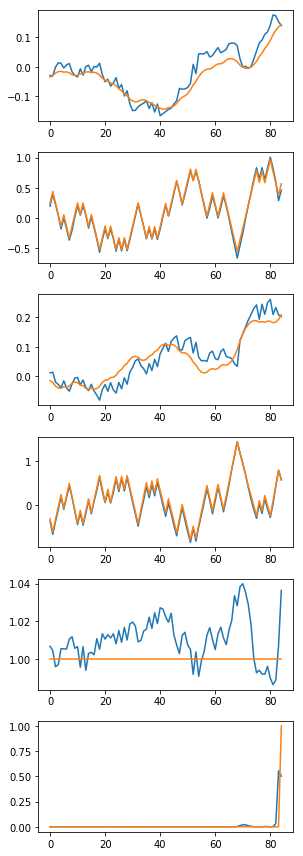

In [11]:
plt.figure(figsize=(8, 12))
for i in range(6):
    plt.subplot(6, 2, 2*i + 1)
    plt.plot(pState[:,i])
    plt.subplot(6,2,2*i+1)
    plt.plot(state_nextsAll[:,i])
plt.tight_layout()